In [3]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import random
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
pd.set_option('display.max_columns', 100)  # or 1000
pd.set_option('display.max_rows', 100)  # or 1000
import time
from numpy import concatenate
Scaler = MinMaxScaler()
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Dropout

In [48]:
# Load testing dataset(Daily data)
def read_daily_df(test_time,features,file): # test_time = pd.Timestamp(yyyy,mm,dd)
    Lake_HydMet = pd.read_csv(file,header = 0,sep = '\t',parse_dates = ['Date'])
    Lake_HydMet = Lake_HydMet[features]
    return Lake_HydMet

In [4]:
# convert series to supervised learning
def series_to_supervised(data, n_in, n_out, var_name,dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1] # number of variables
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(var_name[j]+'(t-%d)' % (i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(var_name[j]+'(t)') for j in range(n_vars)]
        else:
            names += [(var_name[j]+'(t+%d)' % (i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg

In [5]:
# load dataset
def load_dataset(df,var_name):
    values = df[var_name].values
    return values

In [43]:
# reframe dataset
def reframe(values,hyperparameters,var_names):
    reframed = series_to_supervised(values, hyperparameters['time_steps'], hyperparameters['n_out'],var_names)
    reframed = reframed.iloc[hyperparameters['time_steps']:]
    drop_col =[]
    n_var = len(var_names)
    for i in range(1,hyperparameters['time_steps']+1):
        drop_col += [n_var*i-1]
    reframed.drop(reframed.iloc[:,drop_col],axis=1,inplace = True)
    return reframed

In [7]:
def sparse_dataset(data_X,data_y):
    index = []
    y = []
    for i in range(len(data_y)):
        if ~np.isnan(data_y[i]):
            index.append(i)
            y.append(data_y[i])
    X = np.stack(data_X[index,:,:])
    y = np.array(y)
    return index,X,y

In [8]:
def fit_lstm(train_X,train_y,n_batch,nb_epoch,n_neuros,dropout,verbose):
    # design network
    model = Sequential()
    model.add(LSTM(n_neuros,  return_sequences = True,
              input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(dropout))
    model.add(LSTM(n_neuros, return_sequences = True))
    model.add(Dropout(dropout))
    model.add(LSTM(n_neuros))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_X,train_y,epochs =nb_epoch,batch_size = n_batch,verbose = verbose)
    return model

In [9]:
def plot_comparison(df,y,yhat,yhat_ts,n_date,time_steps,index,rmse,r2,nutrient,test_time,ylim):
    # Observation time
    time = df['Date'].iloc[n_date+time_steps:].reset_index()['Date'].iloc[index] 
    # Direct comparison of observation and prediction [yhat] (data point to data point)
    pred = pd.DataFrame(concatenate((yhat.reshape(yhat.shape[0],1),y.reshape(y.shape[0],1)), axis=1),
                        index = time)
    pred.columns = ['Prediction','True value']
    # Extract the continuous timeseries from input dataset
    time_ts = df['Date'].iloc[n_date+time_steps:]
    # The continuous prediction yhat_ts 
    pred_ts = pd.DataFrame(yhat_ts,index = time_ts,columns = ['Prediction'])
    # Compute the 7d rolling mean of the timeseries predction
    pred_ts['Prediction_7d'] = pred_ts['Prediction'].rolling(7,min_periods = 1).mean()
    # Create a continous timeseries without winter gap
    Date = pd.DataFrame(pd.date_range(start = time_ts.iloc[0],
                                  end = time_ts.iloc[-1]),
                    columns = ['Date'])
    pred_ts_gap = Date.merge(pred_ts,how = 'left',on = 'Date')
    f1,ax1 = plt.subplots(1,2,figsize = (18,6),gridspec_kw={'width_ratios': [2, 1]})
    pred_ts_gap.plot(x = 'Date',y = ['Prediction','Prediction_7d'],
                     style = {'Prediction':'b-','Prediction_7d':'k-'},
                     ax = ax1[0])
    pred.plot(y = 'True value',style='ro',alpha = 0.7,ms = 7,ax = ax1[0])
    ax1[0].set_ylabel(nutrient)
    ax1[0].set_xlim((test_time[0],test_time[1]))
    ax1[0].set_ylim(ylim)
    ax1[0].text(0.7, 0.9, 'RMSE:{}'.format(round(rmse,2)), 
            horizontalalignment='center',verticalalignment='center', 
            transform=ax1[0].transAxes,fontsize='x-large')
    pred.plot(x = 'True value', y = 'Prediction',kind = 'scatter',s = 20,c = 'blue',ax = ax1[1])
    ax1[1].plot(pred['True value'],pred['True value'],lw  =1.5,color = 'black')
    ax1[1].text(0.5, 0.8, 'R2:{}'.format(round(r2,2)), 
                horizontalalignment='center',verticalalignment='center', 
                transform=ax1[1].transAxes,fontsize='x-large')
    return f1

In [10]:
def predict_ts(df,nutrient,model,hyperparameters,values):
    # add the predictive values into dataset
    value_X, value_y = values[:, :-1], values[:, -1]
    value_X = value_X.reshape((value_X.shape[0], hyperparameters['time_steps']+1, int(value_X.shape[1]/(hyperparameters['time_steps']+1))))
    y_pred = Scaler.inverse_transform(model.predict(value_X,batch_size = hyperparameters['n_batch']))    
    df[nutrient].iloc[hyperparameters['time_steps']:]=y_pred[:,0]
    df[nutrient].fillna(method = 'backfill',inplace = True)
    return df

In [11]:
def split_dataset(train,test,time_steps):
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], time_steps+1, int(train_X.shape[1]/(time_steps+1))))
    test_X = test_X.reshape((test_X.shape[0], time_steps+1, int(test_X.shape[1]/(time_steps+1))))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    print('number of input timesteps: {}'.format(train_X.shape[1]))
    print('number of features: {}'.format(train_X.shape[2]))
    return train_X, train_y,test_X, test_y

In [12]:
# ensure all data is float
def predict_lstm(df,values,var_name,nutrient,test_time,hyperparameters,ylim):
    n_date = df[df['Date']<test_time[0]]['Date'].count()
    train = values[:n_date, :]
    test = values[n_date:, :]
    train_X, train_y,test_X, test_y = split_dataset(train,test,hyperparameters['time_steps'])
    # fit the lstm model
    index,X,y = sparse_dataset(train_X,train_y) # stack the timeseries input together to create a 2D training input X, and a 1D lable y
    y_scaled = Scaler.fit_transform(y.reshape(-1,1))
    print('number of samples: {}'.format(len(index)))
    kf = KFold(n_splits=5, shuffle=True, random_state=101) # 5-fold cross validation
    RMSE = []
    R2 = []
    # fit the lstm model 
    for train_index, test_index in kf.split(X,y_scaled):
        #print("TRAIN:", len(train_index), "TEST:", len(test_index))
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y_scaled[train_index], y_scaled[test_index]
        model = fit_lstm(X_train,y_train,hyperparameters['n_batch'],hyperparameters['nb_epoch'],
                         hyperparameters['n_neuros'],hyperparameters['dropout'],hyperparameters['verbose'])
        yhat = Scaler.inverse_transform(model.predict(X_test,batch_size = hyperparameters['n_batch']))
        y_test = Scaler.inverse_transform(y_test)
        rmse = sqrt(mean_squared_error(y_test, yhat))
        r2 =  r2_score(y_test, yhat)
        RMSE.append(rmse) 
        R2.append(r2)
        #print('Training RMSE: %.2f' %rmse)       
    # make a prediction
    index,X,y = sparse_dataset(test_X,test_y) # index is the time series
    yhat = Scaler.inverse_transform(model.predict(X,batch_size = hyperparameters['n_batch']))
    rmse = sqrt(mean_squared_error(y, yhat))
    r2 = r2_score(y, yhat)
    print('Test RMSE: %.2f' % rmse)
    print('Test R2: %.2f' %r2)
    # make a prediction for the whole timeseries
    yhat_ts = Scaler.inverse_transform(model.predict(test_X,batch_size = hyperparameters['n_batch']))
    figure = plot_comparison(df,y,yhat,yhat_ts,n_date,hyperparameters['time_steps'],index,rmse,r2,nutrient,test_time,ylim)
    return model,RMSE,R2,figure

In [13]:
## Load training dataset
# Make sure you are in the main folder('..\Algal-bloom-prediction-machine-learning')
os.chdir('Trainning data')
print('Load training data (containing nutrient observations)')
lakename = input('Lake name in short:')
winter = input('Winter data or not? (Y/N)')
if winter =='Y':
    all_df = pd.read_csv(lakename+'_Observation_df.csv',sep = '\t',parse_dates = ['Date'])
else:
    all_df = pd.read_csv(lakename+'_Observation_df_nowinter.csv',sep = '\t',parse_dates = ['Date'])

Load training data (containing nutrient observations)
Lake name in short:LV
Winter data or not? (Y/N)N


In [16]:
# Create the daily df with Nan in nutrients columns
n_Nut = int(input('Number of nutrients: '))
Nut_f = ['Date']
for i in range(n_Nut):
    f = input('Nutrients: ')
    Nut_f.append(f)
print(Nut_f)
Nut = all_df[Nut_f]

Number of nutrients: 8
Nutrients: NO3N
Nutrients: O2
Nutrients: PO4P
Nutrients: NH4N
Nutrients: SiO2
Nutrients: TOTP
Nutrients: TOTN
Nutrients: TOC
['Date', 'NO3N', 'O2', 'PO4P', 'NH4N', 'SiO2', 'TOTP', 'TOTN', 'TOC']


In [18]:
print(all_df.info())
n_feature = int(input('Number of features used for training'))
features = ['Date']
for i in range(n_feature):
    f = input('Feature:')
    features.append(f)
print(features)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259 entries, 0 to 258
Data columns (total 26 columns):
Date                259 non-null datetime64[ns]
chl-a               255 non-null float64
NH4N                224 non-null float64
NO3N                232 non-null float64
PO4P                253 non-null float64
SiO2                244 non-null float64
TOC                 151 non-null float64
TOTN                245 non-null float64
TOTP                253 non-null float64
O2                  206 non-null float64
AirP                246 non-null float64
AirT                246 non-null float64
RelHum              246 non-null float64
SWR                 246 non-null float64
CC                  246 non-null float64
Prec                246 non-null float64
U                   246 non-null float64
delT                246 non-null float64
inflow(m3/s)        246 non-null float64
outflow(m3/s)       246 non-null float64
Ice_d               246 non-null float64
days from iceoff    246 non

In [17]:
# date to seperate training and test sets
test_time = [pd.Timestamp(int(input('test starts in year:')),1,1),pd.Timestamp(int(input('test ends in year:')),1,1)]

test starts in year:2013
test ends in year:2017


In [68]:
# Set directory
#os.chdir('Trainning data')
winter = input('Winter data or not? (Y/N)')
if winter =='Y':
    file = lakename+'_Daily_Observation_df.csv'
else:
    file = lakename+'_Daily_Observation_df_nowinter.csv'
Daily_df = read_daily_df(test_time,features,file) 

Winter data or not? (Y/N)N


In [69]:
# set the hyperparameters
hyperparameters = {'n_batch':10,'nb_epoch':100,'n_neuros':100,'dropout':0.1,'time_steps':7,'n_out':1,'verbose':0}

In [129]:
# predict nutreint 1
nutrient = input('Nutrient: ')
# If add the features from process-based model, add features 'MLD','W','thermD'
#features.pop(0) # Remove 'Date'
#features.append(nutrient)
Nut_memory = Daily_df.merge(pd.concat([Nut['Date'],Nut[nutrient]],axis = 1),how = 'left',on = 'Date')
df = Nut_memory.dropna()
values = load_dataset(df,features) #values = values.astype('float32')
# frame as supervised learning
reframed = reframe(values,hyperparameters,features)
values = reframed.values

Nutrient: NO3N


(149, 8, 15) (149,) (26, 8, 15) (26,)
number of input timesteps: 8
number of features: 15
number of samples: 149
Test RMSE: 222.16
Test R2: 0.16
Training dataset RMSE 105.73 (+/- 25.19)
Training dataset R2 0.77 (+/- 0.11)
Model takes 23 min to run


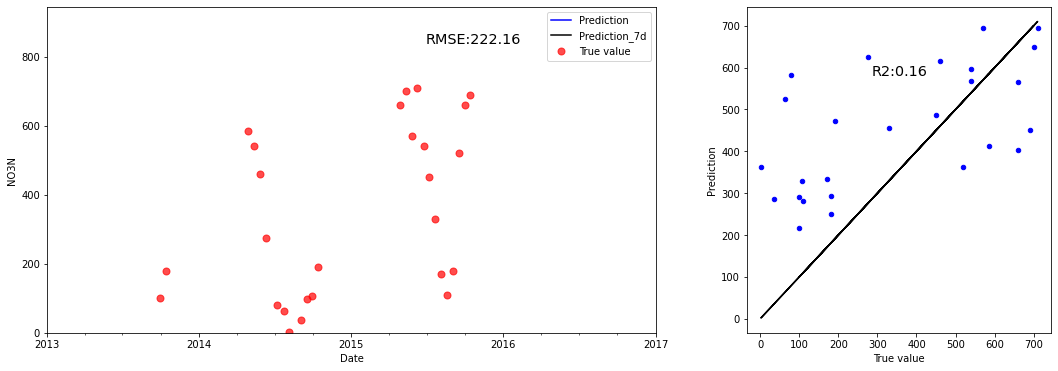

In [130]:
ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,R2,figure = predict_lstm(df,values,features,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig('LSTM_NOX.png',dpi = 500)

In [131]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-131-2b600ecf9f32>", line 2, in <module>
    Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
  File "<ipython-input-10-934583d208c7>", line 6, in predict_ts
    df[nutrient].iloc[hyperparameters['time_steps']:]=y_pred[:,0]
  File "C:\Anaconda3\lib\site-packages\pandas\core\indexing.py", line 205, in __setitem__
    self._setitem_with_indexer(indexer, value)
  File "C:\Anaconda3\lib\site-packages\pandas\core\indexing.py", line 593, in _setitem_with_indexer
    self.obj._data = self.obj._data.setitem(indexer=indexer, value=value)
  File "C:\Anaconda3\lib\site-packages\pandas\core\internals\managers.py", line 560, in setitem
    return self.apply("setitem", **kwargs)
  File "C:\Anaconda3\lib\site-packages\pandas\core\internals\managers.py", line 438, in a

ValueError: cannot set using a slice indexer with a different length than the value

In [ ]:
# predict nutreint 2
nutrient = input('Nutrient: ')

delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)') 

features.append(nutrient)
Nut_memory = Nut_memory.merge(pd.concat([Nut['Date'],Nut[nutrient]],axis = 1),how = 'left',on = 'Date')
df = Nut_memory.dropna()
df = pd.concat([Nut_memory['Date'],Nut_memory[features]],axis = 1).dropna()
values = load_dataset(df,features) #values = values.astype('float32')
# frame as supervised learning
reframed = reframe(values,hyperparameters,features)
values = reframed.values

ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,R2,figure = predict_lstm(df,values,features,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig('LSTM_NOX.png',dpi = 500)